## Data pre-processing and augmentation

In [2]:
from __future__ import print_function, division
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import os
%matplotlib inline 

import matplotlib.pyplot as plt
from PIL import Image
from ipywidgets import interact
from scipy.misc import imresize, imsave

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

## Initialization

In [3]:
# image dimension of the input images
img_width, img_height = 150, 150

# Download the data from Kaggle https://www.kaggle.com/c/dogs-vs-cats/data?train.zip
# One can do it from CLI using Curl 
## e.g. 1. wget -x -c --load-cookies cookies.txt -nH --cut-dirs=5 https://www.kaggle.com/c/dogs-vs-cats/download/train.zip
##      2. create train and validation folders and respectively unzip the downloaded files
train_data_dir = 'data/dogs_vs_cats/train'
validation_data_dir = 'data/dogs_vs_cats/validation'

# Experiment initialization:
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [4]:
from random import randint
def browse_images(dir_path, define_range=10):
    list_of_images = os.listdir(dir_path)
    n = len(list_of_images)
    if define_range > n:
        raise ValueError("out of range")
    def view_image(index):
        im = Image.open('{}{}'.format(dir_path, list_of_images[index]))
        plt.imshow(im, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()
    interact(view_image, index=(0, define_range))

# Quick Exploration of the images

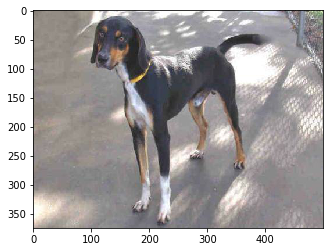

In [5]:
# Explore the dog pictures
browse_images('data/dogs_vs_cats/train/dog/')

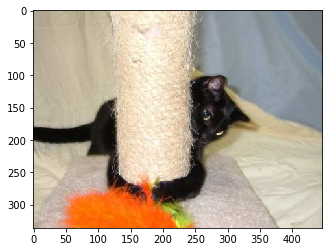

In [6]:
# Explore the cat pictures
browse_images('data/dogs_vs_cats/train/cat/')

## Selecting Backend - Tensorflow or Theano

In [7]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
input_shape

(150, 150, 3)

In [8]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/dogs_vs_cats/train/cat/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)
x.shape

(374, 500, 3)

In [9]:
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='data/dogs_vs_cats/preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 10:
        break  # otherwise the generator would loop indefinitely

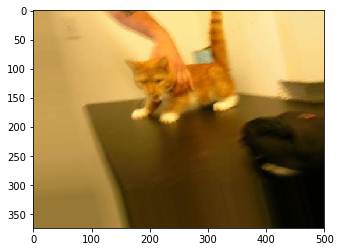

In [10]:
browse_images('data/dogs_vs_cats/preview/')

## Model Architecture

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Data pre-processing

In [12]:
t = load_img('data/dogs_vs_cats/train/cat/cat.0.jpg')
img_to_array(t).shape

(374, 500, 3)

In [13]:
print(os.getcwd())
print(os.path.join(os.getcwd(),'data/dogs_vs_cats/train/', 'dog/'))

/home/deploy/pramit/deep_learning
/home/deploy/pramit/deep_learning/data/dogs_vs_cats/train/dog/


In [7]:
import os
import random
_files = os.listdir('data/dogs_vs_cats/train/dog/')
t = random.sample(range(len(_files)), k=200)
print(_files[5261])

dog.2169.jpg


In [20]:
# split the data into train and test
# Better if this captured as a separate step
def load_train(train_data_path='data/dogs_vs_cats/train/'):
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Loading training images...')
    folders = ["dog", "cat"]
    for fld in folders:
        index = folders.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(os.getcwd(), train_data_path, fld, '*g')
        print(path)
        img_list = glob.glob(path)
        for img_file in img_list:
            flbase = os.path.basename(img_file)
            img = load_img(img_file)
            if len(X_train) <= 2000:
                X_train.append(img)
                X_train_id.append(flbase)
                y_train.append(index)
    
    print('Training data load time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id

In [ ]:
x, y_target, x_id = load_train()
len(x)

Loading training images...
Loading dog files (Index: 0)
/home/deploy/pramit/deep_learning/data/dogs_vs_cats/train/dog/*g


In [ ]:
print(len(x))

In [19]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        'data/dogs_vs_cats/train/',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

validation_generator = test_datagen.flow_from_directory(
        'data/dogs_vs_cats/validation/',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)